# Test `storm_surge_alerts` Module

Render figure object produced by the `nowcast.figures.publish.storm_surge_alerts` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Salish Sea Nowcast system `/results/` parition mounted.

In [1]:
import io
from pathlib import Path

import arrow
import netCDF4 as nc
import scipy.io
import yaml

from salishsea_tools import places

from nowcast.figures.publish import storm_surge_alerts

Python and library versions:

In [2]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import numpy
import sys
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.13.1 | packaged by conda-forge | (main, Jan 13 2025, 09:53:10) [GCC 13.3.0]'
numpy.__version__='2.2.2'
xarray.__version__='2025.1.1'
bottleneck.__version__='1.4.2'
h5netcdf.__version__='1.5.0'
h5py.__version__='3.12.1'
matplotlib.__version__='3.10.0'
cmocean.__version__='v3.0.3'


## Simulate Nowcast System Config

The `config` multiline string contains the pieces of `nowcast/config/nowcast.yaml`
that are needed to set up the conditions as `nowcast.workers.make_plots` does
before calling the figure module `make_figure()` function.

The `yaml.safe_load()` call at the bottom of the cell converts the string into a `config` dict.

In [3]:
config = '''
    bathymetry: /SalishSeaCast/grid/bathymetry_202108.nc
    coastline: /ocean/rich/more/mmapbase/bcgeo/PNW.mat

    ssh:
        tidal_predictions: /SalishSeaCast/tidal-predictions/

    weather:
        ops_dir: /results/forcing/atmospheric/continental2.5/nemo_forcing/

    run:
        results_archive:
            forecast: /results/SalishSea/forecast.202111/
            forecast2: /results/SalishSea/forecast2.202111/
'''

config = yaml.safe_load(io.StringIO(config))

In [4]:
run_date = arrow.get('2025-01-28')
run_type = 'forecast'

dmy = run_date.format('DDMMMYY').lower()
start_day = {
    'nowcast': run_date.format('YYYYMMDD'),
    'forecast': run_date.shift(days=+1).format('YYYYMMDD'),
}
end_day = {
    'nowcast': run_date.format('YYYYMMDD'),
    'forecast': run_date.shift(days=+2).format('YYYYMMDD'),
}
ymd = run_date.format('YYYYMMDD')

results_home = Path(config['run']['results_archive'][run_type])
results_dir = results_home/dmy
place_names = places.TIDE_GAUGE_SITES + places.SUPP_TIDE_SITES
weather_path = Path(config['weather']['ops_dir'])
if run_type in ('forecast', 'foreacst2'):
    weather_path = weather_path/'fcst'

In [5]:
bathy = nc.Dataset(config['bathymetry'])
grid_T_hr = nc.Dataset(
    results_dir / f'SalishSea_1h_{start_day[run_type]}_{end_day[run_type]}_grid_T.nc')
grids_15m = {
    place_name: nc.Dataset(results_dir / f'{place_name.replace(" ", "")}.nc')
    for place_name in place_names
}
weather_path= weather_path
coastline = scipy.io.loadmat(config['coastline'])
tidal_predictions = config['ssh']['tidal_predictions']

/media/doug/warehouse/MEOPAR/tools/SalishSeaTools/salishsea_tools/stormtools.py:524: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ttide = pd.read_csv(
/media/doug/warehouse/MEOPAR/tools/SalishSeaTools/salishsea_tools/stormtools.py:524: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ttide = pd.read_csv(
/media/doug/warehouse/MEOPAR/tools/SalishSeaTools/salishsea_tools/stormtools.py:524: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ttide = pd.read_csv(
/media/doug/warehouse/MEOPAR/tools/SalishSeaTools/salishsea_tools/stormtools.py

5min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


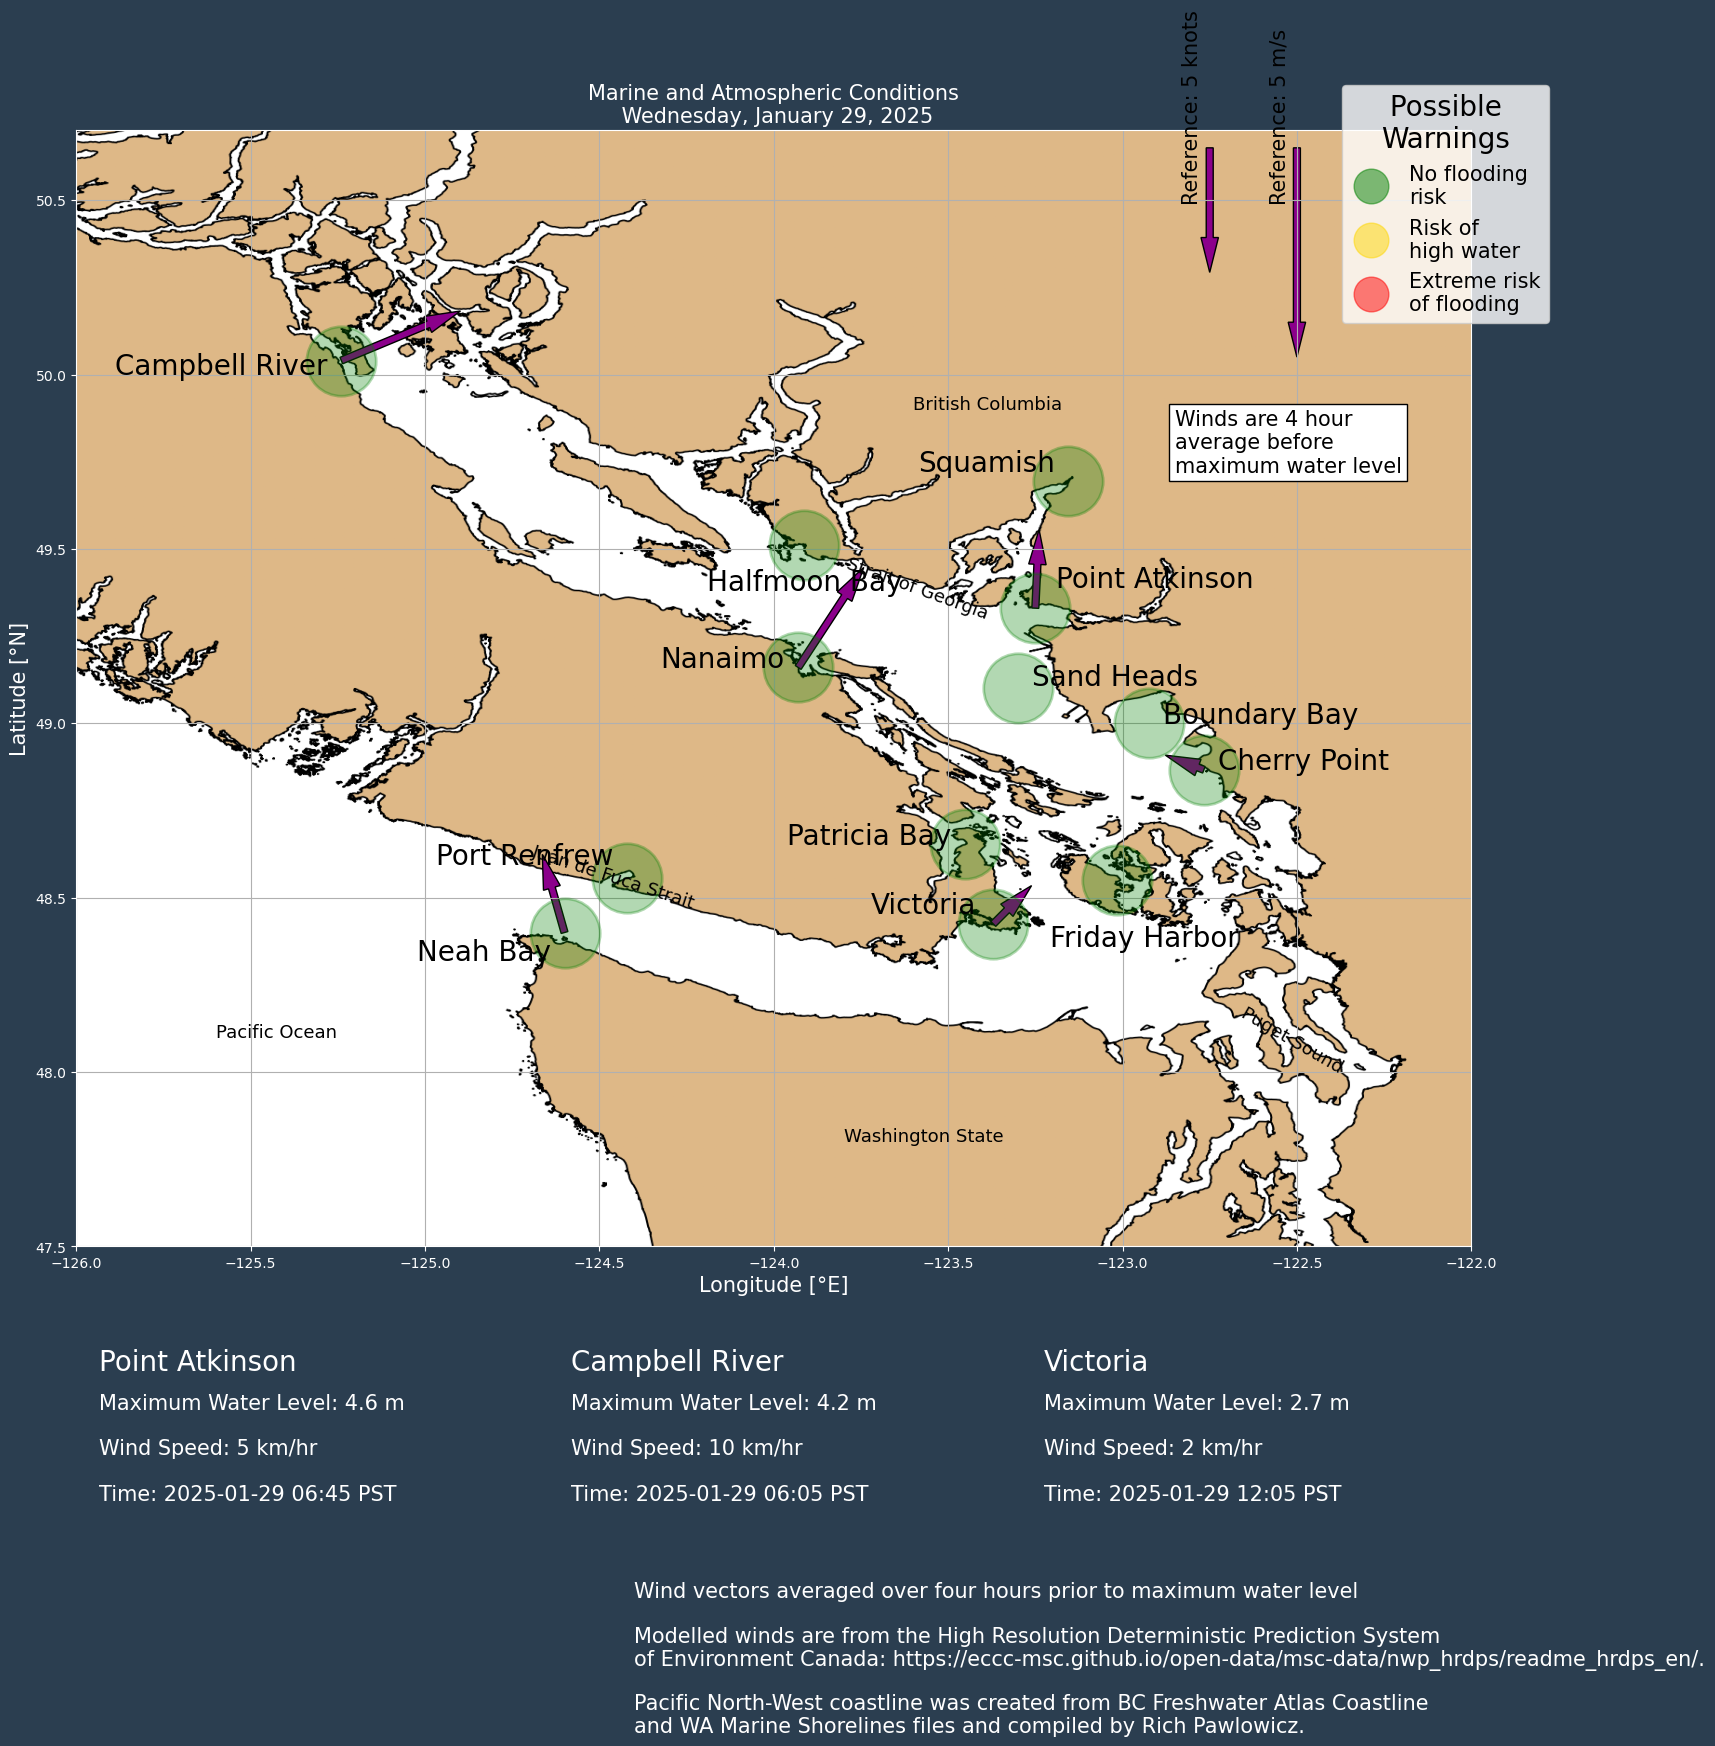

In [6]:
%%timeit -n1 -r1

# Refactored rendering of figure

from importlib import reload
from nowcast.figures import website_theme
reload(storm_surge_alerts)
reload(website_theme)

fig = storm_surge_alerts.make_figure(
    grids_15m, weather_path, coastline, tidal_predictions,
    theme=website_theme)